# TMVA: Machine learning with ROOT

* This tutorial example is based upon the tutorials here: https://indico.scc.kit.edu/indico/event/48/session/4/contribution/35/material/slides/0.pdf and here: https://aholzner.wordpress.com/2011/08/27/a-tmva-example-in-pyroot/
* And the linked comntent here: https://www.dropbox.com/sh/scualho2zcv83hh/AAAnsm-gAqRa-5lX7uPwMH3Ga

* More tutorials on TMVA can be found here: https://twiki.cern.ch/twiki/bin/view/TMVA/WebHome
* Full user documentation of TMVA can be found here: http://tmva.sourceforge.net/docu/TMVAUsersGuide.pdf

In [1]:
import sys
import os
if 'seaborn' not in sys.modules:
    import numpy as np
    import pandas as pd
    %pylab inline
    import seaborn
    from scipy import stats
    from scipy.stats import ttest_ind
    from pylab import pcolor
    import rootnotes
    import root_pandas
    from root_pandas import read_root
    import json
    import requests
    import subprocess as subp
    import ROOT

Populating the interactive namespace from numpy and matplotlib


# Generate and examine test data

In [2]:
# Generate some data with Root
if not os.path.exists('tmvadata.root'):
    ! root $ROOTSYS/tmva/test/createData.C -b
    ! mv data.root tmvadata.root

In [3]:
# Root needs a file for saving information, let's make a temp file for this session
from ROOT import TFile
import tempfile
tdir = tempfile.mkdtemp()
trfile = TFile(tdir + 'tmva_tut.root', 'RECREATE')
trfile.Write()
trfile.cd()

True

In [4]:
exfile = TFile('tmvadata.root')
tree_s = exfile.TreeS
tree_b = exfile.TreeB

In [5]:
ROOT.TBrowser()

<ROOT.TBrowser object ("Browser") at 0x4183910>

In [6]:
df_s = read_root(exfile.GetName(), tree_s.GetName())
df_b = read_root(exfile.GetName(), tree_b.GetName())

In [9]:
df_s.describe()

,var0,var1
count,6000.000000,6000.000000
mean,0.525998,0.313476
std,0.546975,0.739114
min,-0.902526,-1.255960
25%,0.155242,-0.371053
50%,0.687779,0.563091
75%,0.970711,0.973709
max,1.374421,1.418001


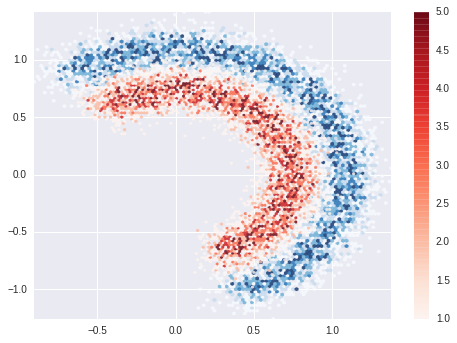

In [10]:
plt.hexbin(df_s.var0, df_s.var1, cmap='Blues', mincnt=1, vmax = 5, alpha=0.8)
plt.hexbin(df_b.var0, df_b.var1, cmap='Reds', mincnt=1, vmax = 5, alpha=0.8)
plt.colorbar()

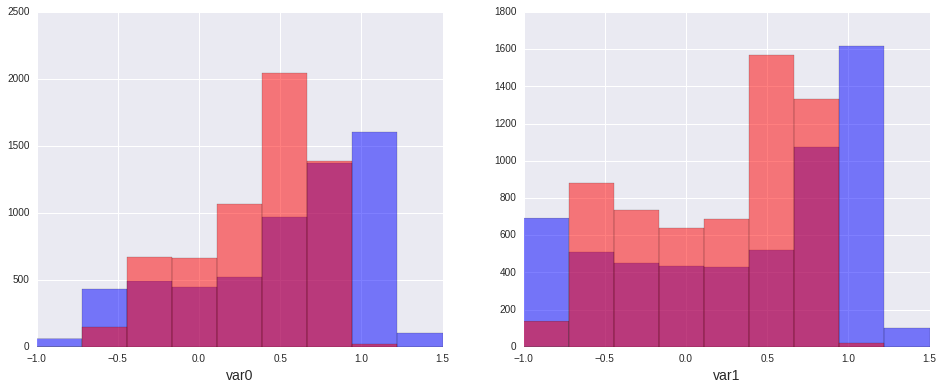

In [11]:
# projections ...
fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(1,2,1)
df_s.var0.hist(bins=np.linspace(-1,1.5,10),color='blue', alpha=0.5)
df_b.var0.hist(bins=np.linspace(-1,1.5,10),color='red', alpha=0.5)
plt.xlabel('var0', fontsize=14)
ax = fig.add_subplot(1,2,2)
df_s.var1.hist(bins=np.linspace(-1,1.5,10),color='blue', alpha=0.5)
df_b.var1.hist(bins=np.linspace(-1,1.5,10),color='red', alpha=0.5)
plt.xlabel('var1', fontsize=14)

# Create BDT: Boosted Decision Tree (random forest)

In [12]:
trfile.cd()

True

In [13]:
# define factory with options
factory = ROOT.TMVA.Factory("TMVAClassification", trfile,
                            ":".join([    "!V",
                                          "!Silent",
                                          "Color",
                                          "DrawProgressBar",
                                          "Transformations=I;D;P;G,D",
                                          "AnalysisType=Classification"]
                                     ))

In [14]:
# add discriminating variables for training
factory.AddVariable("var0","F")
factory.AddVariable("var1","F")
 
# define signal and background trees
factory.AddSignalTree(tree_s)
factory.AddBackgroundTree(tree_b)
 
# define additional cuts 
sigCut = ROOT.TCut("1")
bgCut = ROOT.TCut("1")

## Test three BDTs with different numer of trees and nEventsMin

In [15]:

# book and define methods that should be trained
metho1 = factory.BookMethod(ROOT.TMVA.Types.kBDT, "BDT",
                            ":".join([ "!H",
                                       "!V",
                                       "NTrees=850",
                                       "nEventsMin=150",
                                       "MaxDepth=3",
                                       "BoostType=AdaBoost",
                                       "AdaBoostBeta=0.5",
                                       "SeparationType=GiniIndex",
                                       "nCuts=20",
                                       "PruneMethod=NoPruning",
                                       ]))
 
metho2 = factory.BookMethod(ROOT.TMVA.Types.kBDT, "BDT2",
                            ":".join([ "!H",
                                       "!V",
                                       "NTrees=5",
                                       # "nEventsMin=0",
                                       "MaxDepth=3",
                                       "BoostType=AdaBoost",
                                       "AdaBoostBeta=0.5",
                                       "SeparationType=GiniIndex",
                                       "nCuts=20",
                                       "PruneMethod=NoPruning",
                                       ]))
 
metho3 = factory.BookMethod(ROOT.TMVA.Types.kBDT, "BDT3",
                            ":".join([ "!H",
                                       "!V",
                                       "NTrees=2500",
                                       # "nEventsMin=2",
                                       "MaxDepth=3",
                                       "BoostType=AdaBoost",
                                       "AdaBoostBeta=0.5",
                                       "SeparationType=GiniIndex",
                                       "nCuts=20",
                                       "PruneMethod=NoPruning",
                                       ]))

# Train and evaluate BDT

In [16]:
# set options for trainings
factory.PrepareTrainingAndTestTree(sigCut, 
                                   bgCut, 
                                   ":".join(["nTrain_Signal=0",
                                             "nTrain_Background=0",
                                             "SplitMode=Random",
                                             "NormMode=NumEvents",
                                             "!V"
                                             ]))

In [17]:
# self-explaining
factory.TrainAllMethods()
factory.TestAllMethods()
factory.EvaluateAllMethods()

# Make ROC curve

In [18]:
from ROOT import TFile, TCanvas, TColor, gStyle, TLegend, TLatex, TH1F, TTree, TH2F
from math import sqrt
from array import array

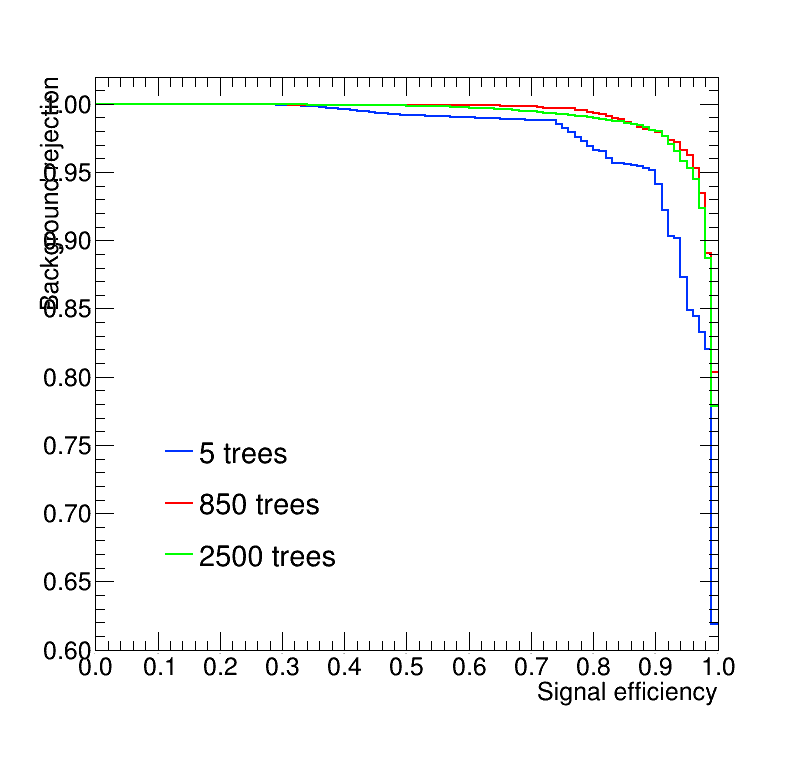

<ROOT.TCanvas object ("c1") at 0x7c49bf0>

In [19]:
gStyle.SetOptStat(0)
gStyle.SetLabelSize(0.06,"xy")
gStyle.SetTitleSize(0.06,"xy")
gStyle.SetTitleOffset(1.2,"xy")
gStyle.SetTitleOffset(1.2,"xy")
gStyle.SetPadTopMargin(0.1)
gStyle.SetPadRightMargin(0.1)
gStyle.SetPadBottomMargin(0.16)
gStyle.SetPadLeftMargin(0.12)
 
canvas = TCanvas("c1","c1", 800, 800)
canvas.SetTickx()
canvas.SetTicky()
 
h2 = trfile.Get("Method_BDT/BDT/MVA_BDT_rejBvsS")
h1 = trfile.Get("Method_BDT/BDT2/MVA_BDT2_rejBvsS")
h3 = trfile.Get("Method_BDT/BDT3/MVA_BDT3_rejBvsS")
 
h1.SetTitle('')
h1.GetYaxis().SetTitle('Background rejection')
h1.GetXaxis().SetDecimals()
h1.GetYaxis().SetDecimals()
h1.GetXaxis().SetTitle('Signal efficiency')
     
h1.SetLineColor(TColor.kAzure)
h1.SetLineWidth(2)
h1.SetFillStyle(0)
h1.SetFillColor(TColor.kAzure-2)
 
h2.SetLineColor(TColor.kRed)
h2.SetLineWidth(2)
h2.SetFillStyle(0)
h3.SetLineColor(TColor.kGreen)
h3.SetLineWidth(2)
h3.SetFillStyle(0)
#h2.SetFillColor(TColor.kAzure-2)
 
l = TLegend(0.2, 0.25, 0.4, 0.45)
l.SetTextSize(0.04)
l.SetTextFont(42)
l.SetFillColor(10)
l.SetLineColor(10)
l.SetBorderSize(0)
l.AddEntry(h1,"5 trees","l")
l.AddEntry(h2,"850 trees","l")
l.AddEntry(h3,"2500 trees","l")
 
h1.Draw("HIST")
h2.Draw("HISTsame")
h3.Draw("HISTsame")
l.Draw("same")
canvas.RedrawAxis()
canvas

# Read and apply classifier

In [20]:
reader = ROOT.TMVA.Reader()

In [21]:
import array
varx = array.array('f',[0]) ; reader.AddVariable("var0",varx)
vary = array.array('f',[0]) ; reader.AddVariable("var1",vary)

In [22]:
reader.BookMVA("BDT2","weights/TMVAClassification_BDT2.weights.xml")

<ROOT.TMVA::MethodBDT object ("BDT2") at 0x80f6be0>

In [23]:
def retrieve(var0, var1):
        varx[0]= var0
        vary[0]= var1
        return reader.EvaluateMVA("BDT2")

In [24]:
# Make an applied Dataframe

In [25]:
xs = np.linspace(df_s.var0.min(),df_s.var0.max(),20)
ys = np.linspace(df_s.var1.min(),df_s.var1.max(),20)
applied = pd.DataFrame(columns=['var0','var1','result'])
for x in xs:
    for y in ys:
        applied = applied.append({"var0" : x, "var1" : y, "result" : retrieve(x,y)},True)

In [26]:
applied.head()

,var0,var1,result
0,-0.902526,-1.255960,0.745253
1,-0.902526,-1.115225,0.745253
2,-0.902526,-0.974490,0.745253
3,-0.902526,-0.833755,0.745253
4,-0.902526,-0.693021,-0.224302


In [27]:
# make an applied 2D plot

In [28]:
X,Y = np.meshgrid(xs,ys)
Z = np.zeros((20,20))

for i in range(20):
   for j in range(20):
       Z[i,j] = retrieve(X[i,j],Y[i,j])

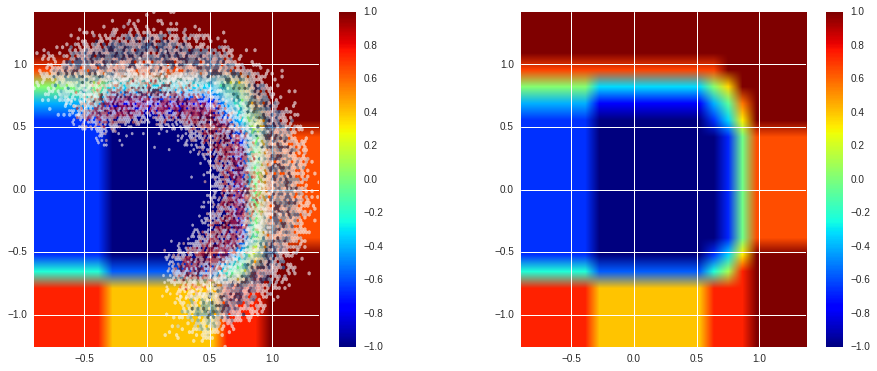

In [29]:
fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(1,2,1)
plt.imshow(Z, extent=[df_s.var0.min(),df_s.var0.max(),df_s.var1.min(),df_s.var1.max()], cmap='jet', origin='lower')
plt.colorbar()
plt.hexbin(df_s.var0, df_s.var1, cmap='Blues', mincnt=1, vmax = 5, alpha=0.6)
plt.hexbin(df_b.var0, df_b.var1, cmap='Reds', mincnt=1, vmax = 5, alpha=0.6)
ax = fig.add_subplot(1,2,2)
plt.imshow(Z, extent=[df_s.var0.min(),df_s.var0.max(),df_s.var1.min(),df_s.var1.max()], cmap='jet', origin='lower')
plt.colorbar()

In [30]:
%load_ext watermark
%watermark -a KAVE -d -t -v -p numpy,pandas -g

KAVE 2016-09-01 17:30:55 

CPython 2.7.12
IPython 4.0.1

numpy 1.10.1
pandas 0.17.1
Git hash: e682a8ce36d019fff0ee6067182136550a222d07
